<a href="https://colab.research.google.com/github/yukanaya24/project-1_cvbasic/blob/enomoto/enomoto_super_resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# On how to train and test a deep neural network for the super-resolution task.
> Prepared by Man M. Ho


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Computer Vision

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Computer Vision


# Import Libraries

In [5]:
# For Path Processing
from os.path import exists, join, basename
from os import makedirs, remove, getcwd, listdir

# To download and extract datasets
from six.moves import urllib
import tarfile

# For Datasets and Transformation
from PIL import Image
import torch.utils.data as data
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize

# For Network Architecture
import torch
import torch.nn as nn
import torch.nn.init as init

# PyTorch Optimizer
import torch.optim as optim

# Others
import numpy as np
from math import log10
import matplotlib.pyplot as plt # For plotting

# Data Preparation and Dataset

Here is the Python code for downloading and extracting the dataset.

In [6]:
def download_bsds300(dest="dataset"):
    current_dir = getcwd()
    output_image_dir = join(current_dir, dest, "BSDS300/images")

    if not exists(output_image_dir):
        makedirs(dest)
        url = "http://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz"
        print("Downloading Dataset at ", url)

        data = urllib.request.urlopen(url)

        file_path = join(dest, basename(url))
        with open(file_path, 'wb') as f:
            f.write(data.read())

        print("Extracting Data")
        with tarfile.open(file_path) as tar:
            for item in tar:
                tar.extract(item, dest)

        remove(file_path)
    print('Done! Extracted Dataset is saved at : ' + join(output_image_dir))

In [7]:
download_bsds300()

Extracting Data
Done! Extracted Dataset is saved at : /content/gdrive/MyDrive/Computer Vision/dataset/BSDS300/images


Now we have downloaded the dataset, let's prepare for the dataloader!

In [8]:
# Check whether your file ends with the exts ".png", ".jpg", and ".jpeg".
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])

# Load image using PIL.Image and convert RGB to YCbCr,
# where: Y is luma/gray component, Cb and CR are chroma/color components.
# In this work, we only up-sample the Y.
def load_img(filepath):
    img = Image.open(filepath).convert('YCbCr')
    y, _, _ = img.split()
    return y

class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, input_transform=None, target_transform=None):
        super(DatasetFromFolder, self).__init__()
        self.image_filenames = [join(image_dir, x) for x in listdir(image_dir) if is_image_file(x)]

        self.input_transform = input_transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        # Load Images
        input = load_img(self.image_filenames[index])
        target = input.copy()

        # Input is resize 1/scale as described in the function input_transform
        if self.input_transform:
            input = self.input_transform(input)
        # Target is the original image
        if self.target_transform:
            target = self.target_transform(target)

        return input, target

    def __len__(self):
        return len(self.image_filenames)

# result the suitable crop_size for upscale_factor
def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)


def input_transform(crop_size, upscale_factor):
    return Compose([
        CenterCrop(crop_size),
        Resize(crop_size // upscale_factor),
        ToTensor(),
    ])


def target_transform(crop_size):
    return Compose([
        CenterCrop(crop_size),
        ToTensor(),
    ])


# This result Pytorch Dataset for training
def get_training_set(root_dir, upscale_factor):
    train_dir = join(root_dir, "train")
    crop_size = calculate_valid_crop_size(256, upscale_factor)

    return DatasetFromFolder(train_dir,
                             input_transform=input_transform(crop_size, upscale_factor),
                             target_transform=target_transform(crop_size))

# This result Pytorch Dataset for testing
def get_test_set(root_dir, upscale_factor):
    test_dir = join(root_dir, "test")
    crop_size = calculate_valid_crop_size(256, upscale_factor)

    return DatasetFromFolder(test_dir,
                             input_transform=input_transform(crop_size, upscale_factor),
                             target_transform=target_transform(crop_size))


# Network Architecture
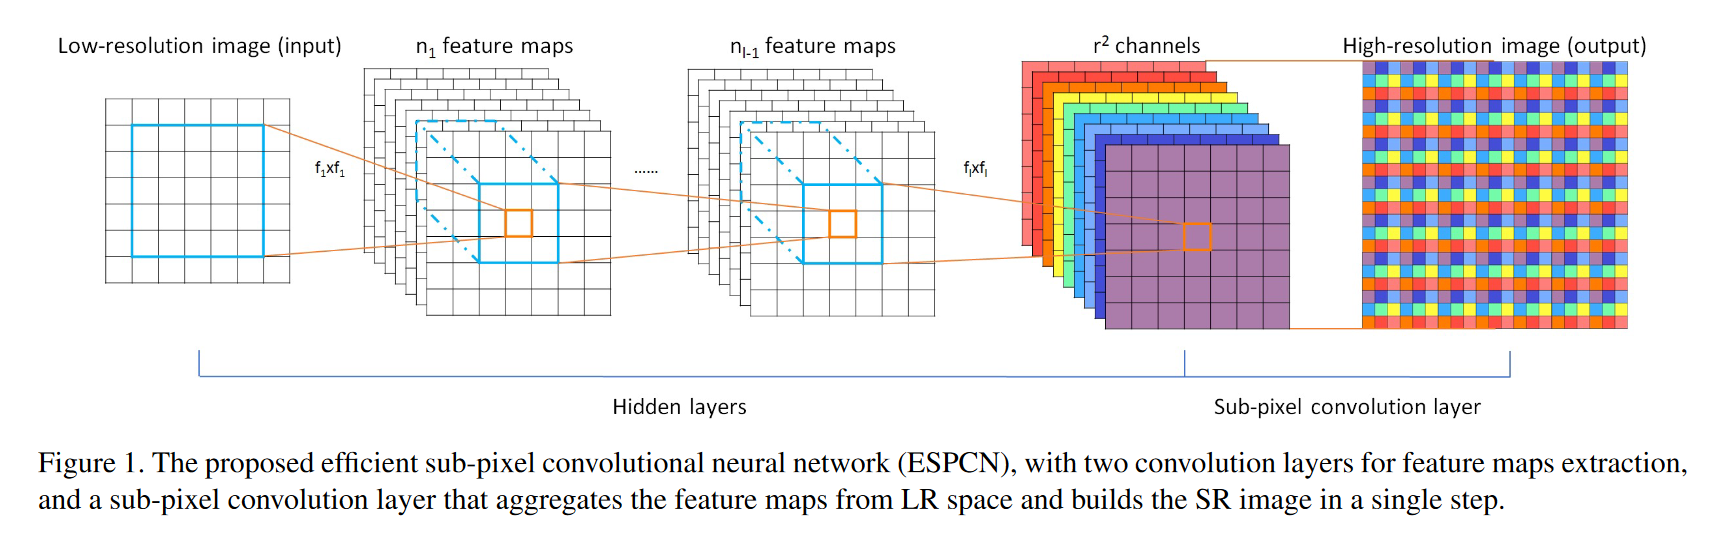

Regarding the network architecture, we utilize Efficient Sub-Pixel Convolutional Neural Network (ESPCN, https://arxiv.org/pdf/1609.05158.pdf
) with N convolutional layers (they set N=4 in the code), the feature size in the inference order are as:

---
Input Y: H x W x 1

---
Conv1 x ReLU:

H x W x 1 --> H x W x 64

---
Conv2 x ReLU:

H x W x 64 --> H x W x 64

---
Conv3 x ReLU:

H x W x 64 --> H x W x 32

---
Conv4:

H x W x 32 --> H x W x (upscale_factor ** 2)

---
Pixel_Shuffle:

H x W x (upscale_factor ** 2) --> H' x W' x 1

where:

H' = H * upscale_factor

W' = W * upscale_factor

Pixel shuffle technique converts a feature map of H x W x (upscale_factor**2) to the high-resolution output image H' x W' x 1

---
A code for the network is as:

In [9]:
class Net(nn.Module):
    def __init__(self, upscale_factor):
        super(Net, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x

    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)


# Train Models

## Set hyperparameters

In [10]:
args = {}
# here is where BSD300 dataset is saved
args['root_dir'] = './dataset/BSDS300/images'
# super resolution upscale factor
args['upscale_factor'] = 2
# training batch size
args['batchSize'] = 64
# testing batch size
args['testBatchSize'] = 10
# number of epochs to train for
args['nEpochs'] = 50
# Learning Rate
args['lr'] = 0.01
# number of threads for data loader to use
args['threads'] = 4
# random seed to use
args['seed'] = 42

## This keeps your random function consistent for every run so that you can reproduce your results.

In [11]:
torch.manual_seed(args['seed'])

## Declare training and test dataloader

In [12]:
train_set = get_training_set(args['root_dir'], args['upscale_factor'])
test_set = get_test_set(args['root_dir'], args['upscale_factor'])
training_data_loader = DataLoader(dataset=train_set, num_workers=args['threads'], batch_size=args['batchSize'], shuffle=True)
testing_data_loader = DataLoader(dataset=test_set, num_workers=args['threads'], batch_size=args['testBatchSize'], shuffle=False)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Declare model and criteria

In [13]:
model = Net(upscale_factor=args['upscale_factor']).cuda()
training_loss_fn = nn.MSELoss()
mse_fn = nn.MSELoss()

## Declare optimizer

Adam: https://arxiv.org/abs/1412.6980

In [14]:
optimizer = optim.Adam(model.parameters(), lr=args['lr'])

## Training function

In [15]:
def train(epoch):
    print('Epoch: {}'.format(epoch))
    epoch_loss = 0
    for iteration, batch in enumerate(training_data_loader, 1):
        input, target = batch[0].cuda(), batch[1].cuda()

        optimizer.zero_grad()
        loss = training_loss_fn(model(input), target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        # print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(training_data_loader), loss.item()))

    print("===> Train: Avg. Loss: {:.4f}".format(epoch_loss / len(training_data_loader)))
    return epoch_loss / len(training_data_loader)

## Test function

In [16]:
def test():
    avg_psnr = 0
    with torch.no_grad():
        for batch in testing_data_loader:
            input, target = batch[0].cuda(), batch[1].cuda()

            prediction = model(input)
            mse = mse_fn(prediction, target)
            psnr = 10 * log10(1 / mse.item())
            avg_psnr += psnr
    print("===> Test: Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))
    return avg_psnr / len(testing_data_loader)

## Save checkpoint

In [17]:
def save_checkpoint(epoch, model_name='model'):
    model_out_path = model_name + "_epoch_{}.pth".format(epoch)
    torch.save(model, model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))

## Train models

We are using BSDS300 dataset, MSE for the loss function, and a network architecture with 4 convolutional layers.

Epoch: 1
===> Train: Avg. Loss: 3.2332
===> Test: Avg. PSNR: 6.1559 dB
Epoch: 2
===> Train: Avg. Loss: 0.1819
===> Test: Avg. PSNR: 12.2286 dB
Epoch: 3
===> Train: Avg. Loss: 0.0603
===> Test: Avg. PSNR: 15.0750 dB
Epoch: 4
===> Train: Avg. Loss: 0.0318
===> Test: Avg. PSNR: 12.5776 dB
Epoch: 5
===> Train: Avg. Loss: 0.0470
===> Test: Avg. PSNR: 16.5381 dB
Epoch: 6
===> Train: Avg. Loss: 0.0247
===> Test: Avg. PSNR: 16.6655 dB
Epoch: 7
===> Train: Avg. Loss: 0.0194
===> Test: Avg. PSNR: 16.6922 dB
Epoch: 8
===> Train: Avg. Loss: 0.0203
===> Test: Avg. PSNR: 17.4075 dB
Epoch: 9
===> Train: Avg. Loss: 0.0177
===> Test: Avg. PSNR: 17.7339 dB
Epoch: 10
===> Train: Avg. Loss: 0.0153
===> Test: Avg. PSNR: 17.8775 dB
Epoch: 11
===> Train: Avg. Loss: 0.0139
===> Test: Avg. PSNR: 18.2635 dB
Epoch: 12
===> Train: Avg. Loss: 0.0143
===> Test: Avg. PSNR: 18.6615 dB
Epoch: 13
===> Train: Avg. Loss: 0.0117
===> Test: Avg. PSNR: 18.8525 dB
Epoch: 14
===> Train: Avg. Loss: 0.0121
===> Test: Avg. PSNR:

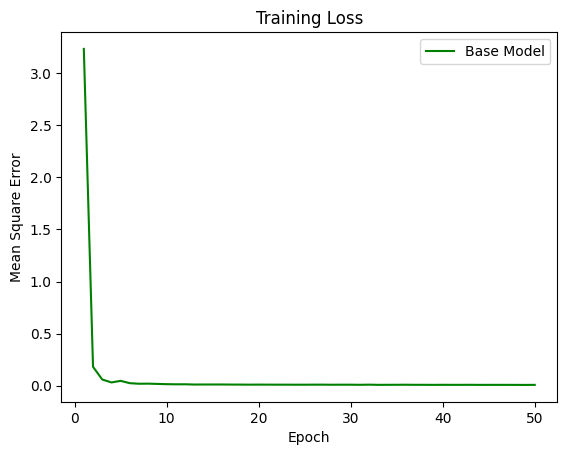

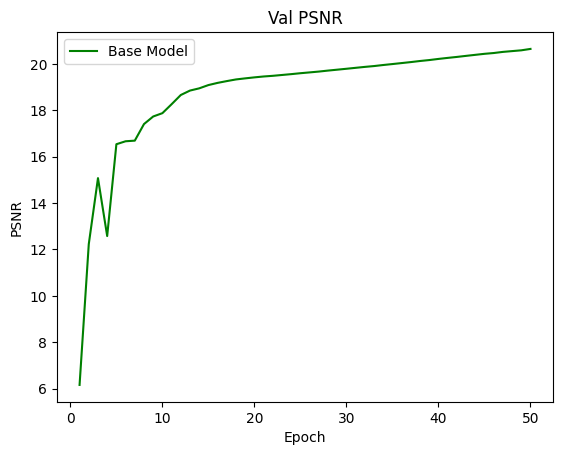

In [18]:
base_train_errors = []
base_test_psnrs = []
for epoch in range(1, args['nEpochs'] + 1):
    train_error = train(epoch)
    test_psnr = test()
    base_train_errors.append(train_error)
    base_test_psnrs.append(test_psnr)

save_checkpoint(args['nEpochs'], model_name='model_base')

# Plotting errors
## Note for plot function, Args from left to right:
### range,
### list of values,
### color such as 'g' -> green, 'b' --> blue, 'r' --> red
#### See more colors here https://matplotlib.org/stable/gallery/color/named_colors.html
### label
plt.figure()
plt.plot(range(1, args['nEpochs'] + 1), base_train_errors, 'g', label='Base Model')
# plt.plot(range(1, args['nEpochs'] + 1), bsds500_train_errors, 'b', label='BSDS500 Model') # You can add another model like this
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, args['nEpochs'] + 1), base_test_psnrs, 'g', label='Base Model')
# plt.plot(range(1, args['nEpochs'] + 1), bsds500_test_psnrs, 'b', label='Base Model')# You can add another model like this
plt.title('Val PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.legend()
plt.show()

# Tasks
Task 1.学習済みモデルを用いて、1枚の画像に対するテスト結果を確認する（20点）

Task 2.損失関数に関するアブレーションスタディを実施する。各損失関数を用いた際のモデル性能（PSNR）を比較する。（30点）

Task 3.ネットワーク構造やハイパーパラメータなどを調整し、性能（PSNR）の向上を図る（50点）

上記に示したトレーニング損失や検証時のPSNRのプロット方法を参考にしてください。


##Task 1. Test the trained model on your own images

The run function is as:

In [ ]:
def run_model(input_image, output_filename, model_path):
  img = Image.open(input_image).convert('YCbCr')
  y, cb, cr = img.split()

  model = torch.load(model_path, weights_only=False)
  img_to_tensor = ToTensor()
  input = img_to_tensor(y).view(1, -1, y.size[1], y.size[0])

  model = model.cuda()
  input = input.cuda()

  out = model(input)
  out = out.cpu()
  out_img_y = out[0].detach().numpy()
  out_img_y *= 255.0
  out_img_y = out_img_y.clip(0, 255)
  out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')

  out_img_cb = cb.resize(out_img_y.size, Image.BICUBIC)
  out_img_cr = cr.resize(out_img_y.size, Image.BICUBIC)
  out_img = Image.merge('YCbCr', [out_img_y, out_img_cb, out_img_cr]).convert('RGB')

  out_img.save(output_filename)
  print('Output image saved to ', output_filename)
  return img.convert('RGB'), out_img

In [ ]:
# An example
input_image = "./dataset/BSDS300/images/test/101085.jpg"
output_filename = "101085_x2.jpg"

model_path = "model_base_epoch_50.pth"
img, out_img = run_model(input_image, output_filename, model_path)

Output image saved to  101085_x2.jpg


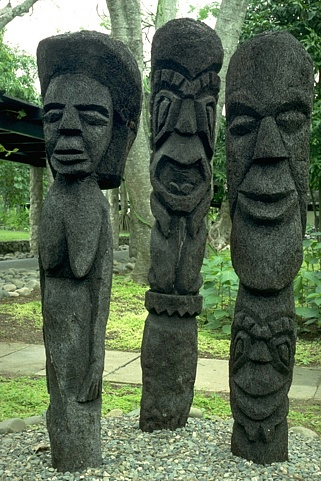

In [ ]:
img #test内の画像でもいいし、好きな写真でもいい解像度が拡大されているか確認

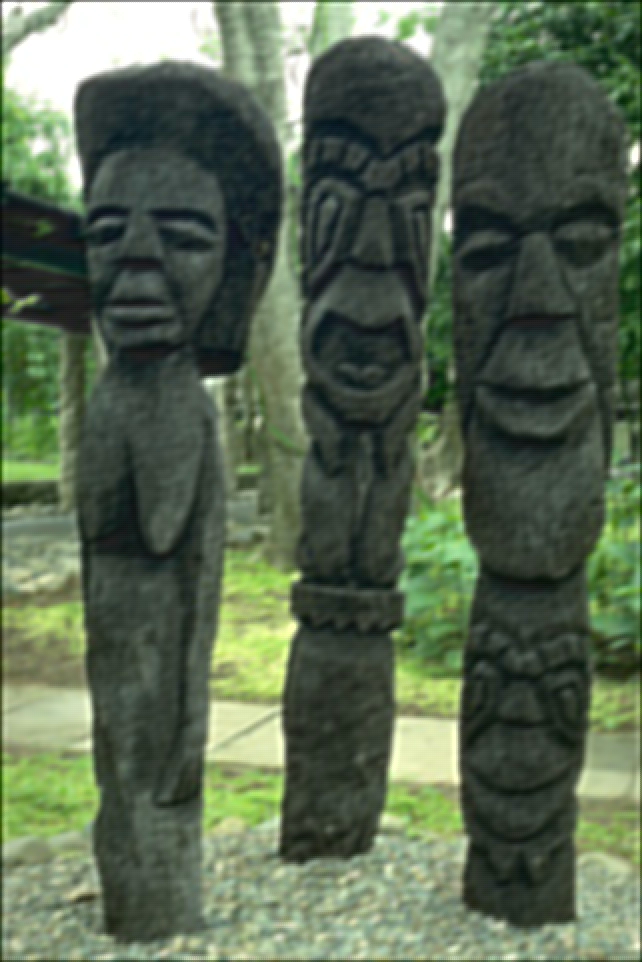

In [ ]:
out_img

##Task 2. Conduct an ablation study on loss function.

MSE（Mean Square Error：平均二乗誤差）以外にも、画像生成に用いられる損失関数は多数存在します。以下はその一部です：

L1: https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html#torch.nn.L1Loss

L1 Smooth: https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html#torch.nn.SmoothL1Loss

Huber Loss: https://pytorch.org/docs/stable/generated/torch.nn.HuberLoss.html#torch.nn.HuberLoss

MS-SSIM: https://github.com/jorge-pessoa/pytorch-msssim

LPIPS: https://github.com/richzhang/PerceptualSimilarity

MSE以外の損失関数に変更し、結果を分析してください。
以下はL1損失関数に変更する例です。

In [ ]:
# Baseline, training_loss_fn is commented for changing
torch.manual_seed(args['seed'])
model = Net(upscale_factor=args['upscale_factor']).cuda()
# training_loss_fn = nn.MSELoss()  ←MSEを使う場合
mse_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=args['lr'])
train_set = get_training_set(args['root_dir'], args['upscale_factor'])
test_set = get_test_set(args['root_dir'], args['upscale_factor'])
training_data_loader = DataLoader(dataset=train_set, num_workers=args['threads'], batch_size=args['batchSize'], shuffle=True)
testing_data_loader = DataLoader(dataset=test_set, num_workers=args['threads'], batch_size=args['testBatchSize'], shuffle=False)

# Change the Training Loss Function
training_loss_fn = nn.L1Loss()

l1loss_train_errors = []
l1loss_test_psnrs = []

for epoch in range(1, args['nEpochs'] + 1):
    train_error = train(epoch)
    test_psnr = test()
    l1loss_train_errors.append(train_error)
    l1loss_test_psnrs.append(test_psnr)

save_checkpoint(args['nEpochs'], model_name='model_l1loss')

## Plotting below, please refer the previous code for how to plot training loss and validation PSNR.
##下に上のような図をplotして、L1lossを使うときの図を確認
##L1lossの方がモデルの性能が良い　PSRだけで比較



Epoch: 1
===> Train: Avg. Loss: 1.5053
===> Test: Avg. PSNR: 6.7014 dB
Epoch: 2
===> Train: Avg. Loss: 0.3072
===> Test: Avg. PSNR: 12.3000 dB
Epoch: 3
===> Train: Avg. Loss: 0.1671
===> Test: Avg. PSNR: 13.5666 dB
Epoch: 4
===> Train: Avg. Loss: 0.1514
===> Test: Avg. PSNR: 17.2337 dB
Epoch: 5
===> Train: Avg. Loss: 0.1067
===> Test: Avg. PSNR: 16.1189 dB
Epoch: 6
===> Train: Avg. Loss: 0.0972
===> Test: Avg. PSNR: 18.3968 dB
Epoch: 7
===> Train: Avg. Loss: 0.0792
===> Test: Avg. PSNR: 18.6192 dB
Epoch: 8
===> Train: Avg. Loss: 0.0727
===> Test: Avg. PSNR: 18.8681 dB
Epoch: 9
===> Train: Avg. Loss: 0.0699
===> Test: Avg. PSNR: 19.9339 dB
Epoch: 10
===> Train: Avg. Loss: 0.0702
===> Test: Avg. PSNR: 20.1012 dB
Epoch: 11
===> Train: Avg. Loss: 0.0649
===> Test: Avg. PSNR: 20.7522 dB
Epoch: 12
===> Train: Avg. Loss: 0.0603
===> Test: Avg. PSNR: 20.2308 dB
Epoch: 13
===> Train: Avg. Loss: 0.0608
===> Test: Avg. PSNR: 21.2312 dB
Epoch: 14
===> Train: Avg. Loss: 0.0564
===> Test: Avg. PSNR:

##Task 3 Optimization

###3.1 Modify hyper parameters

In [ ]:
torch.manual_seed(args['seed'])
model = Net(upscale_factor=args['upscale_factor']).cuda()
training_loss_fn = nn.MSELoss()
mse_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=args['lr'])
train_set = get_training_set(args['root_dir'], args['upscale_factor'])
test_set = get_test_set(args['root_dir'], args['upscale_factor'])
training_data_loader = DataLoader(dataset=train_set, num_workers=args['threads'], batch_size=args['batchSize'], shuffle=True)
testing_data_loader = DataLoader(dataset=test_set, num_workers=args['threads'], batch_size=args['testBatchSize'], shuffle=False)



args['nEpochs'] = 500

epoch500extend_train_errors = []
epoch500extend_test_psnrs = []

for epoch in range(1, args['nEpochs']  + 1):
    train_error = train(epoch)
    test_psnr = test()
    epoch500extend_train_errors.append(train_error)
    epoch500extend_test_psnrs.append(test_psnr)

save_checkpoint(args['nEpochs'], model_name='model_epoch500extend')

## Plotting below, please refer the previous code for how to plot training loss and validation PSNR.



Epoch: 1
===> Train: Avg. Loss: 3.0903
===> Test: Avg. PSNR: 6.1871 dB
Epoch: 2
===> Train: Avg. Loss: 0.1746
===> Test: Avg. PSNR: 12.7856 dB
Epoch: 3
===> Train: Avg. Loss: 0.0545
===> Test: Avg. PSNR: 15.5962 dB
Epoch: 4
===> Train: Avg. Loss: 0.0295
===> Test: Avg. PSNR: 12.8162 dB
Epoch: 5
===> Train: Avg. Loss: 0.0444
===> Test: Avg. PSNR: 16.5177 dB
Epoch: 6
===> Train: Avg. Loss: 0.0279
===> Test: Avg. PSNR: 16.1451 dB
Epoch: 7
===> Train: Avg. Loss: 0.0203
===> Test: Avg. PSNR: 16.1746 dB
Epoch: 8
===> Train: Avg. Loss: 0.0208
===> Test: Avg. PSNR: 17.3183 dB
Epoch: 9
===> Train: Avg. Loss: 0.0181
===> Test: Avg. PSNR: 17.5436 dB
Epoch: 10
===> Train: Avg. Loss: 0.0167
===> Test: Avg. PSNR: 17.7344 dB
Epoch: 11
===> Train: Avg. Loss: 0.0160
===> Test: Avg. PSNR: 18.1970 dB
Epoch: 12
===> Train: Avg. Loss: 0.0142
===> Test: Avg. PSNR: 18.6292 dB
Epoch: 13
===> Train: Avg. Loss: 0.0129
===> Test: Avg. PSNR: 18.8050 dB
Epoch: 14
===> Train: Avg. Loss: 0.0122
===> Test: Avg. PSNR:

###3.2 Change network architecture

The baseline architecture is as:

---
Input Y: H x W x 1

---
Conv1 x ReLU:

H x W x 1 --> H x W x 64

---
Conv2 x ReLU:

H x W x 64 --> H x W x 64

---
Conv3 x ReLU:

H x W x 64 --> H x W x 32

---
Conv4:

H x W x 32 --> H x W x (upscale_factor ** 2)

---
Pixel_Shuffle:

H x W x (upscale_factor ** 2) --> H' x W' x 1

---

And the code is as:

```
self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
self.conv4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
self.pixel_shuffle = nn.PixelShuffle(upscale_factor)
```

In [ ]:
# Net
class Net(nn.Module):
    def __init__(self, upscale_factor):
        super(Net, self).__init__()

        ## Baseline
        # self.relu = nn.ReLU()
        # self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
        # self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        # self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        # self.conv4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        # self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        ## Code your network below


        self._initialize_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x

    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)


# Baseline
torch.manual_seed(args['seed'])
model = Net(upscale_factor=args['upscale_factor']).cuda()
training_loss_fn = nn.MSELoss()
mse_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=args['lr'])
train_set = get_training_set(args['root_dir'], args['upscale_factor'])
test_set = get_test_set(args['root_dir'], args['upscale_factor'])
training_data_loader = DataLoader(dataset=train_set, num_workers=args['threads'], batch_size=args['batchSize'], shuffle=True)
testing_data_loader = DataLoader(dataset=test_set, num_workers=args['threads'], batch_size=args['testBatchSize'], shuffle=False)

extendNet_train_errors = []
extendNet_test_psnrs = []

for epoch in range(1, args['nEpochs'] + 1):
    train_error = train(epoch)
    test_psnr = test()
    extendNet_train_errors.append(train_error)
    extendNet_test_psnrs.append(test_psnr)
save_checkpoint(args['nEpochs'], model_name='model_extendNet')

## Plotting below, please refer the previous code for how to plot training loss and validation PSNR.

# References:

PyTorch Examples: https://github.com/pytorch/examples/

Plotting: https://www.pluralsight.com/guides/data-visualization-deep-learning-model-using-matplotlib

Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network: https://arxiv.org/pdf/1609.05158.pdf
